The Framingham Heart Study: Predicting the 10 year risk factors

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from numpy import mean

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

sns.set_palette('RdYlGn')

In [6]:
# Creating the data frame
data = pd.read_csv('data/frmgham2.csv')

# Reading the head of data frame
data.head()

,RANDID,SEX,TOTCHOL,AGE,SYSBP,DIABP,CURSMOKE,CIGPDAY,BMI,DIABETES,...,CVD,HYPERTEN,TIMEAP,TIMEMI,TIMEMIFC,TIMECHD,TIMESTRK,TIMECVD,TIMEDTH,TIMEHYP
0,2448,1,195.0,39,106.0,70.0,0,0.0,26.97,0,...,1,0,8766,6438,6438,6438,8766,6438,8766,8766
1,2448,1,209.0,52,121.0,66.0,0,0.0,NaN,0,...,1,0,8766,6438,6438,6438,8766,6438,8766,8766
2,6238,2,250.0,46,121.0,81.0,0,0.0,28.73,0,...,0,0,8766,8766,8766,8766,8766,8766,8766,8766
3,6238,2,260.0,52,105.0,69.5,0,0.0,29.43,0,...,0,0,8766,8766,8766,8766,8766,8766,8766,8766
4,6238,2,237.0,58,108.0,66.0,0,0.0,28.50,0,...,0,0,8766,8766,8766,8766,8766,8766,8766,8766


# Exploratory Data Analysis

The first step before creating the machine learing model, is the exploratory data analysis (EDA) , to better understand the data. EDA could contain various methods but for the shake of simplicity, here I perform only some visual ones.

The Framingham Heart Study found many risk factors contributing in increasing the risk of CHD, such as smoking and high cholesterol levels.
Let's examine some of these risk factors, and find if these insights are observed in this dataset.

In 1960, smoking was found to increase the risk of CHD. Let's see if this is evident in the data.

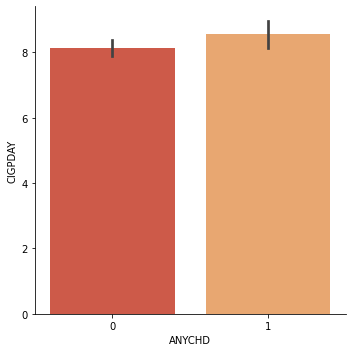

In [7]:
sns.catplot(x='ANYCHD', y='CIGPDAY', kind='bar', data=data)

It can be seen that patients who have some kind of CHD smoke more cigarettes per day than those who do not, although the difference is subtle.

Next is the relation to cholesterol and blood pressure. In 1961, it was found that these two factors relate to an increased number of CHD.

<AxesSubplot:xlabel='ANYCHD', ylabel='DIABP'>

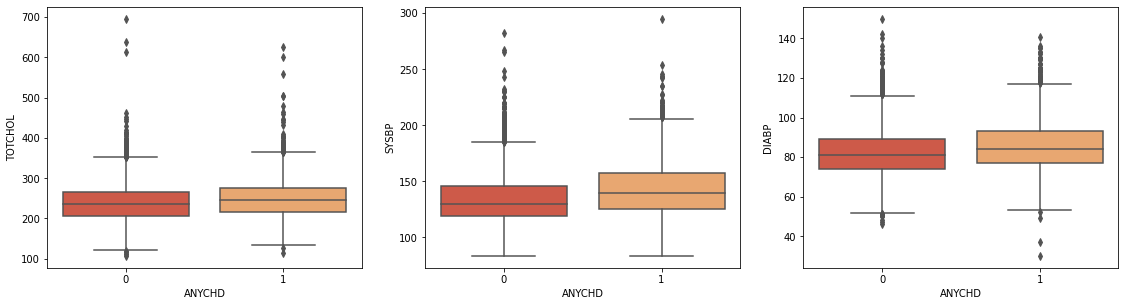

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(19.2,4.8))

sns.boxplot(x='ANYCHD', y='TOTCHOL', data=data, ax=ax[0])
sns.boxplot(x='ANYCHD', y='SYSBP', data=data, ax=ax[1])
sns.boxplot(x='ANYCHD', y='DIABP', data=data, ax=ax[2])

From here, it can be seen that patients with higher levels of cholesterol and blood pressure (both systolic and diastolic) are more likely to develop CHD. For cholesterol this observation is very subtle and maybe not significant, because the specific feature contains both LDL and HDL. However, in 1988 only LDL was found to increase the risk of CHD, while HDL (the good cholesterol) was actually proven to decrease it.

In 1999, the lifetime risk of developing CHD was found to be higher in men than in women.

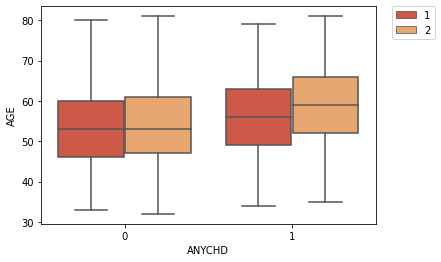

In [28]:
sns.boxplot(x='ANYCHD',y='AGE',hue='SEX',data=data)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

It can be seen that men present some kind of CHD earlier in their lifes, when compared to women.

In 2002, obesity was found to be a risk factor in developing CHD. Let's check this through BMI feature.

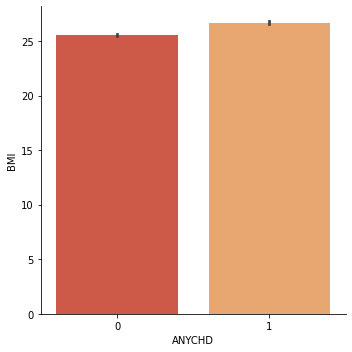

In [26]:
sns.catplot(x='ANYCHD',y='BMI',kind='bar',data=data)

Patients with CHD are seen to have slightly higher BMI than patients without.

Some other factors may be interesting too. Specifically, let's look at:
- the relationship between age, prevalent stroke, and the risk of developing CHD.
- the variables age, diabetes, and the risk of developing CHD.
- blood pressure medication and the risk of developing CHD.

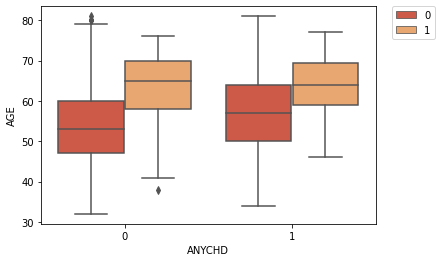

In [18]:
sns.boxplot(x='ANYCHD',y='AGE',hue='PREVSTRK',data=data)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

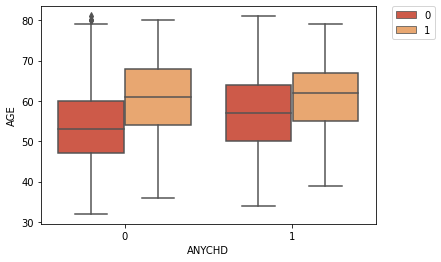

In [19]:
sns.boxplot(x='ANYCHD',y='AGE',hue='DIABETES',data=data)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

It looks like strokes and diabetes are more prevalent in participants of an older age group.

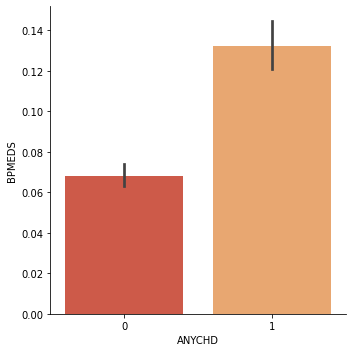

In [27]:
sns.catplot(x='ANYCHD',y='BPMEDS',kind='bar',data=data)

A higher dosage of blood pressure medication is associated with a larger CHD risk. This may mean that patients with more severe blood pressure issues are related to an increased risk of CHD.

# Data Preprocessing

After EDA, some data preprocessing is needed before passing the data to the model. First, let's check for empty values

In [29]:
# Checking for null values
data.isnull().any()

RANDID      False
SEX         False
TOTCHOL      True
AGE         False
SYSBP       False
DIABP       False
CURSMOKE    False
CIGPDAY      True
BMI          True
DIABETES    False
BPMEDS       True
HEARTRTE     True
GLUCOSE      True
educ         True
PREVCHD     False
PREVAP      False
PREVMI      False
PREVSTRK    False
PREVHYP     False
TIME        False
PERIOD      False
HDLC         True
LDLC         True
DEATH       False
ANGINA      False
HOSPMI      False
MI_FCHD     False
ANYCHD      False
STROKE      False
CVD         False
HYPERTEN    False
TIMEAP      False
TIMEMI      False
TIMEMIFC    False
TIMECHD     False
TIMESTRK    False
TIMECVD     False
TIMEDTH     False
TIMEHYP     False
dtype: bool

Ok, there are features with empty values. For simplicity let's drop them.

In [30]:
# Dropping null values
data_without_nan = data.dropna()

In [31]:
data_without_nan.isnull().any()

RANDID      False
SEX         False
TOTCHOL     False
AGE         False
SYSBP       False
DIABP       False
CURSMOKE    False
CIGPDAY     False
BMI         False
DIABETES    False
BPMEDS      False
HEARTRTE    False
GLUCOSE     False
educ        False
PREVCHD     False
PREVAP      False
PREVMI      False
PREVSTRK    False
PREVHYP     False
TIME        False
PERIOD      False
HDLC        False
LDLC        False
DEATH       False
ANGINA      False
HOSPMI      False
MI_FCHD     False
ANYCHD      False
STROKE      False
CVD         False
HYPERTEN    False
TIMEAP      False
TIMEMI      False
TIMEMIFC    False
TIMECHD     False
TIMESTRK    False
TIMECVD     False
TIMEDTH     False
TIMEHYP     False
dtype: bool

The model to classify the risk of CHD needs to perform better than the baseline. A baseline model is a model that classifies everything into the majority class.

In [32]:
data_without_nan['ANYCHD'].value_counts()

0    1663
1     573
Name: ANYCHD, dtype: int64

Here, the majority class is 0, or absence of CHD. The baseline accuracy is computed:

In [33]:
# Baseline accuracy:
1663/(1663+573)

0.7437388193202147

The model needs to beat the baseline accuracy of 0.74.

# Train-test split

The task that we are going to address is the prediction of any kind of CHD event. Thus the actual value is binary, where 0 means that no even

In [54]:
X = data_without_nan.drop('ANYCHD',axis=1)
y = data_without_nan['ANYCHD']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

# Over and under-sampling

The data set is unbalanced, and ~75% of the data are participants who don't have a CHD risk. To overcome this, oversampling and undersampling are employed (this is one of many available techniques). Then, a pipeline for a decision tree classifier is created. Be careful here! To not bias the model training, oversampling and undersampling are applied only on the train data and not on the test ones. If test data were also affected, some of the synthetic test data would be included in the training as well, producing a rather optimistic result, ultimately.

In [56]:
steps = [('over', RandomOverSampler(sampling_strategy='minority')), ('under', RandomUnderSampler()), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)

# Fitting the data to the pipeline

In [57]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('over', RandomOverSampler(sampling_strategy='minority')),
                ('under', RandomUnderSampler()),
                ('model', DecisionTreeClassifier())])

# Making predictions on test data

In [58]:
y_pred = pipeline.predict(X_test)

# Evaluating the model

In [59]:
from sklearn.metrics import classification_report,accuracy_score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       492
           1       1.00      0.98      0.99       179

    accuracy                           0.99       671
   macro avg       1.00      0.99      0.99       671
weighted avg       0.99      0.99      0.99       671



In [60]:
accuracy_score(y_test, y_pred)

0.9940387481371088

The model achieves near perfect precision, recall, f1 and accuracy, outperforming the baseline.